## Sagnac Frequency - Backscatter Correction - RV - Temperature

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert


In [2]:
from functions.backscatter_correction import __backscatter_correction
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.interpolate_nan import __interpolate_nan
from functions.smoothing import __smooth
from functions.get_stream import __get_stream
from functions.reduce import __reduce


In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'

## Configurations

In [33]:
config = {}

# case
config['tbeg'] = UTCDateTime("2024-07-16 00:00")
config['tend'] = UTCDateTime("2024-07-19 12:00")

# set limits
flim1, flim2 = 447.733, 447.746

# specify path to data
config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"

# specify path to store figures
config['path_to_figures'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"


### Load MLTI Data

In [34]:
# load data for RV
mlti = read_pickle(config['path_to_data']+"rv_temperature_mlti.pkl")

# get mlti intervals
mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)


In [35]:
# load data for RU
mltiU = read_pickle(config['path_to_data']+"rv_temperature_mltiU.pkl")

# get mlti intervals
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)


### Load maintenenace log

In [36]:
lxx = read_pickle(config['path_to_data']+f"rv_temperature_lxx.pkl")

### Load Beat Data

In [37]:
bs = read_pickle(config['path_to_data']+"rv_temperature_beatv.pkl")

In [38]:
beatU = read_pickle(config['path_to_data']+"rv_temperature_beatu.pkl")

### Load Temperature Data

In [39]:
ps1 = read(config['path_to_data']+"rv_temperature_ps1.mseed")
ps7 = read(config['path_to_data']+"rv_temperature_ps7.mseed")
ps9 = read(config['path_to_data']+"rv_temperature_ps9.mseed")


### Data Processing

In [40]:
# prepare relateive times
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

# cut data period
bs = bs[(bs.time1 >= config['tbeg']) & (bs.time2 <= config['tend'])]

In [41]:
# compute backscatter corrected signal
bs['fj_bs'], _, _ = __backscatter_correction(bs.f1_ac / bs.f1_dc,
                                             bs.f2_ac / bs.f2_dc,
                                             np.unwrap(bs.f1_phw) - np.unwrap(bs.f2_phw),
                                             bs.fj_fs,
                                             np.nanmedian(bs.fj_fs),
                                             cm_filter_factor=1.033,
                                             )


In [42]:
# Cut corrupt data periods
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [43]:
# remove mlti intervals
bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

In [44]:
# interpolate NaN data
bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))


In [45]:
# moving average
n_minutes = 600

beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

In [46]:
# process temperature data
ps_sum = ps1[0].data+ps7[0].data+ps9[0].data
psx = __get_stream(ps_sum, ps1[0].stats.delta, "BW.PROMY.XX.LKI", ps1[0].stats.starttime)
psz = __get_stream(ps_sum, ps1[0].stats.delta, "BW.PROMY.ZZ.LKI", ps1[0].stats.starttime)

ps = Stream()
ps += ps1
ps += ps7
ps += ps9
ps += psx
ps += psz

ps = ps.merge()

for tr in ps:
    tr.data = __reduce(tr.data, 10)

# ps.plot();

### Plotting

/tmp/ipykernel_756030/3733657830.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


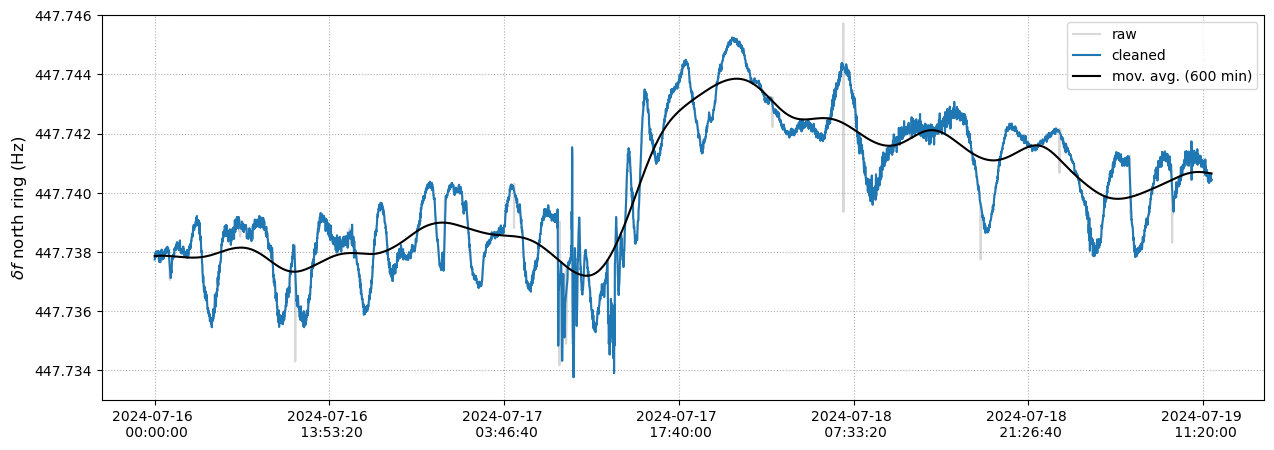

In [47]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


447.7375185537858


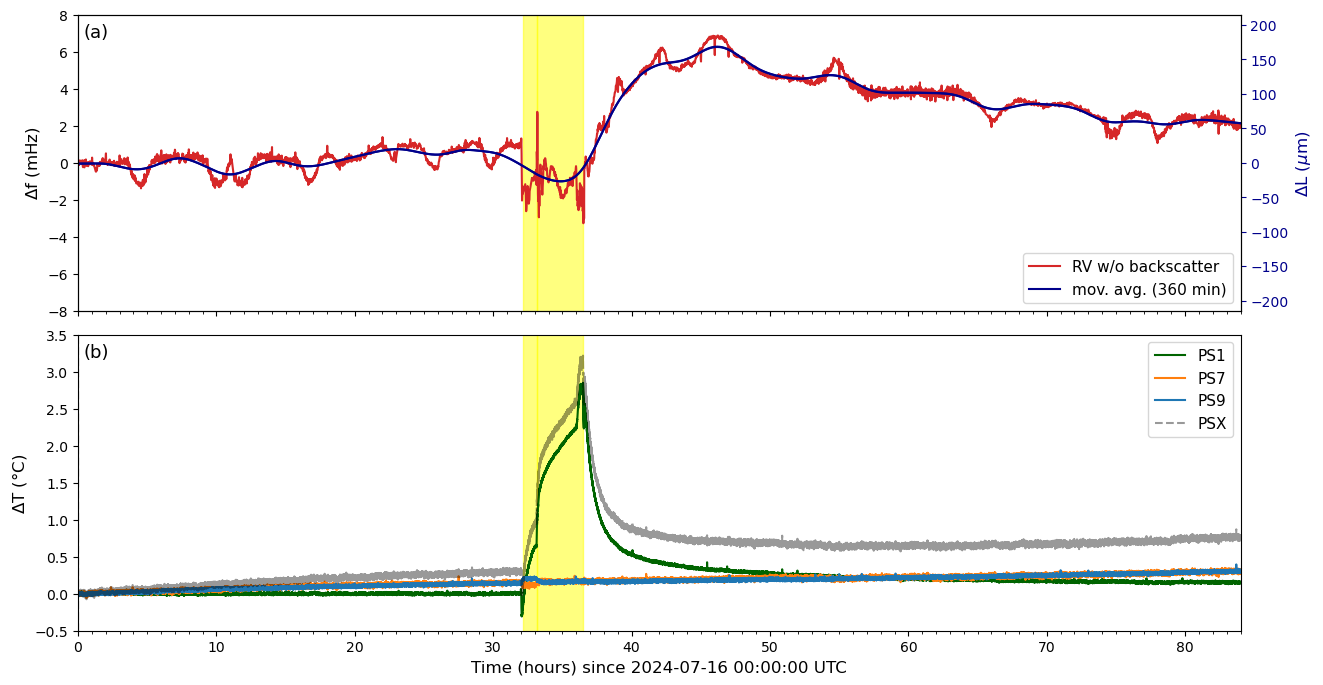

In [52]:
def __makeplot(key1, key2):

    import mpl_axes_aligner
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    factor = -0.5
    df0 = __smooth(__reduce(beatU.fj_inter, 200), 6*60) * factor
    df0_time = beatU.times_utc_sec

    df1 = __reduce(bs[key1], 10)
    df2 = __reduce(bs[key2], 10)

    nmin = 6*60
    df3 = __smooth(__reduce(bs[key2], 10), nmin)

    reftime = bs.time1.iloc[0]

    f0 = np.nanmean(bs[key2][:10])
    print(f0)

    dL = 12.0 * df3 / f0

    # manual offest to align zeros
    # dL += 57.1

    dT = np.gradient(ps.select(location="01")[0].data) / ps.select(location="01")[0].stats.delta

    # ___________________________________________

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/3600, "hours"

    fscale, funit = 1e3, "mHz"

    lscale, lunit = 1e6, r"$\mu$m"

    dTscale, dTunit = 60, r"°C/min"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.08)

    # _____________________________________________________________________________

    # ax[0].plot(df0_time*tscale, df0*fscale, color="tab:green", label=f"{factor}x RU w/ backscatter")

    # ax[0].plot(bs.time_sec*tscale, df1*fscale, color="black", label=f"RV w/ backscatter")
    ax[0].plot(bs.time_sec*tscale, df2*fscale, color="tab:red", label=f"RV w/o backscatter")
    ax[0].plot(bs.time_sec*tscale, df3*fscale, color="darkblue", label=f"mov. avg. ({nmin} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(-8, 8)

    # _____________________________________________________________________________

    ax000 = ax[0].twinx()
    ax000.plot(bs.time_sec*tscale, dL*lscale, color="darkblue")
    ax000.set_ylim(ax000.get_yticks()[0], 215)
    ax000.set_ylabel(f"$\Delta$L ({lunit})", fontsize=font, color="darkblue")
    ax000.tick_params(axis='y', colors="darkblue")
    mpl_axes_aligner.align.yaxes(ax[0], 0, ax000, 0, 0.5)
    # ax000.set_yticks(np.linspace(ax000.get_yticks()[0], ax000.get_yticks()[-1], len(ax[0].get_yticks())))

    # _____________________________________________________________________________

    ax[1].plot(ps.select(location="01")[0].times(reftime=reftime)*tscale, ps.select(location="01")[0].data,
               color="darkgreen", label="PS1")
    ax[1].plot(ps.select(location="07")[0].times(reftime=reftime)*tscale, ps.select(location="07")[0].data,
               color="tab:orange", label=f"PS7")
    ax[1].plot(ps.select(location="09")[0].times(reftime=reftime)*tscale, ps.select(location="09")[0].data,
               color="tab:blue", label=f"PS9")
    ax[1].plot(ps.select(location="XX")[0].times(reftime=reftime)*tscale, ps.select(location="XX")[0].data,
               color="k", label=f"PSX", ls="--", alpha=0.4)

    # _____________________________________________________________________________

    # ax111 = ax[1].twinx()
    # ax111.plot(ps.select(location="01")[0].times(reftime=reftime)*tscale, dT*dTscale,
    #            color="green", label=f"", alpha=0.6)
    # ax111.set_ylabel(f"dT/dt ({dTunit})", fontsize=font, color="green")
    # ax111.set_ylim(-0.4, 0.4)
    # [t.set_color('green') for t in ax111.yaxis.get_ticklabels()]

    # _____________________________________________________________________________

    ax[0].set_xlim(0, max(bs.time_sec)*tscale)

    ax[0].legend(loc=4, fontsize=font-1)
    ax[1].legend(loc=1, fontsize=font-1)

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)
    ax[1].set_ylabel("$\Delta$T (°C)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    # add dates to x-axis
    # ref_date = str(bs.time1.iloc[0])[:10]
    # tcks = ax[1].get_xticks()
    # tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    # ax[1].set_xticklabels(tcklbls)

    # add maintenance intervals
    for lx1, lx2 in zip(lxx.t1, lxx.t2):
        lx1_sec = (lx1-UTCDateTime(reftime))*tscale
        lx2_sec = (lx2-UTCDateTime(reftime))*tscale
        ax[0].fill_betweenx([-10, 10], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax[1].fill_betweenx([-10, 10], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    # add manual (not triggered in shaft 03 automatically)
    tstart = (lxx.t1[0]-UTCDateTime(reftime))*tscale
    ax[0].fill_betweenx([-10, 10], tstart-1, tstart, color="yellow", alpha=0.5)
    ax[1].fill_betweenx([-10, 10], tstart-1, tstart, color="yellow", alpha=0.5)

    # ax[0].set_ylim(-8, 8)
    ax[1].set_ylim(-0.5, 3.5)

    # adjust ticks
    ax[0].xaxis.set_major_locator(MultipleLocator(10))
    ax[0].xaxis.set_minor_locator(MultipleLocator(1))

    # set sublabels
    for _k, ll in enumerate(['(a)', '(b)']):
        ax[_k].text(0.005, 0.97, ll, ha="left", va="top", transform=ax[_k].transAxes, fontsize=font+1)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot("fj_fs_inter", "fj_bs_inter");

fig.savefig(config['path_to_figures']+f"SF_BS_RV_temperature.png", format="png", dpi=150, bbox_inches='tight')
